<a href="https://colab.research.google.com/github/rahiakela/nlp-research-and-practice/blob/main/llms-notebooks/06_fine_tuning_custom_dataset_with_lora_for_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [ ]:
!pip install accelerate==0.21.0
!pip install appdirs==1.4.4
!pip install bitsandbytes==0.40.2
!pip install datasets==2.10.1
!pip install fire==0.5.0
!pip install peft==0.4.0
!pip install transformers==4.31.0
!pip install sentencepiece==0.1.97
!pip install tensorboardX==2.6
!pip install gradio==3.23.0

In [2]:
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import sys
import json
from typing import List

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

import fire
import torch
from datasets import load_dataset
from huggingface_hub import notebook_login
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams

%matplotlib inline
sns.set(rc={'figure.figsize':(10, 7)})
sns.set(rc={'figure.dpi':100})
sns.set(style='white', palette='muted', font_scale=1.2)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
notebook_login()

##Data

In [4]:
# let's download  BTC Tweets Sentiment dataset
!gdown 1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN

Downloading...
From: https://drive.google.com/uc?id=1xQ89cpZCnafsW5T3G3ZQWvR7q682t2BN
To: /content/bitcoin-sentiment-tweets.csv
100% 242k/242k [00:00<00:00, 3.53MB/s]


In [5]:
data_df = pd.read_csv("bitcoin-sentiment-tweets.csv")
data_df.head()

,date,tweet,sentiment
0,Fri Mar 23 00:40:40 +0000 2018,@p0nd3ea Bitcoin wasn't built to live on excha...,1.0
1,Fri Mar 23 00:40:40 +0000 2018,@historyinflicks Buddy if I had whatever serie...,1.0
2,Fri Mar 23 00:40:42 +0000 2018,@eatBCH @Bitcoin @signalapp @myWickr @Samsung ...,0.0
3,Fri Mar 23 00:41:04 +0000 2018,@aantonop Even if Bitcoin crash tomorrow morni...,0.0
4,Fri Mar 23 00:41:07 +0000 2018,I am experimenting whether I can live only wit...,1.0


In [8]:
# let's see shape of data
data_df.shape

(1897, 3)

In [6]:
# Let's have a look at response variable distribution
data_df.sentiment.value_counts()

 0.0    860
 1.0    779
-1.0    258
Name: sentiment, dtype: int64

In [9]:
# percent breakdown of response variable
data_df.sentiment.value_counts(normalize=True)

 0.0    0.453347
 1.0    0.410648
-1.0    0.136004
Name: sentiment, dtype: float64

<Axes: >

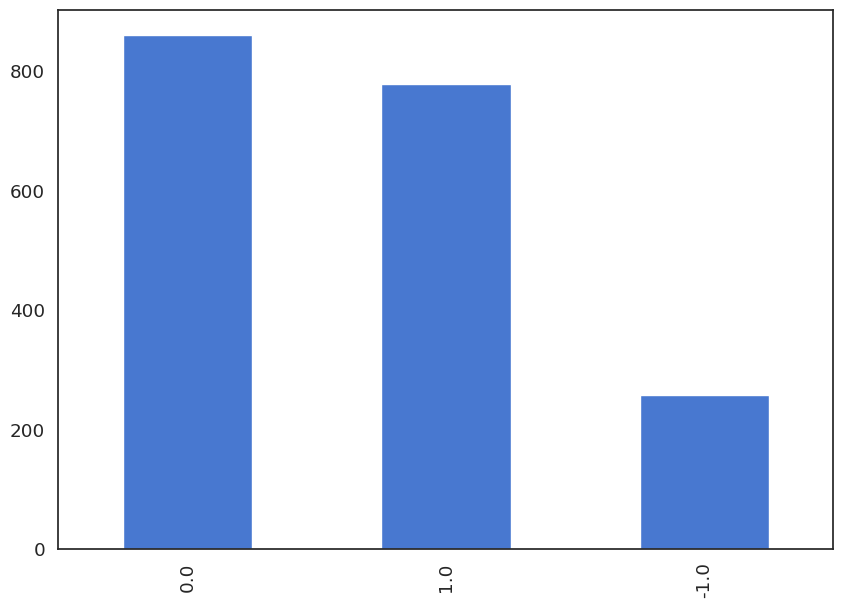

In [7]:
data_df.sentiment.value_counts().plot(kind="bar")

##Build JSON Dataset

In [6]:
# Let's convert the Pandas dataframe into a JSON file that adheres to the format in the original Alpaca dataset
def label_sentiment(score: float):
  if score > 0:
    return "Positive"
  elif score < 0:
    return "Negative"
  else:
    return "Neutral"

In [7]:
json_dataset = [
    {
        "instruction": "Detect the sentiment of the tweet.",
        "input": row["tweet"],
        "output": label_sentiment(row["sentiment"])
    } for row in data_df.to_dict(orient="records")  # read data row-wise
]

json_dataset[0]

{'instruction': 'Detect the sentiment of the tweet.',
 'input': "@p0nd3ea Bitcoin wasn't built to live on exchanges.",
 'output': 'Positive'}

In [12]:
json_dataset[2]

{'instruction': 'Detect the sentiment of the tweet.',
 'input': '@eatBCH @Bitcoin @signalapp @myWickr @Samsung @tipprbot patience is truly a virtue',
 'output': 'Neutral'}

In [8]:
# save the generated JSON file to use it later
with open("alpaca-bitcoin-sentiment-dataset.json", "w") as f:
  json.dump(json_dataset, f)

##Pretrained Model

In [ ]:
BASE_MODEL = "baffo32/decapoda-research-llama-7B-hf"

liama_model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,  # loads the model using 8-bit quantization to reduce memory usage
    torch_dtype=torch.float16,
    device_map="auto"
)

liama_tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)

liama_tokenizer.pad_token_id = (0)    # set 0 to represent unknown token
liama_tokenizer.padding_side = "left" # pad sequences on the left side

##Data tokenizing

In [ ]:
json_data = load_dataset("json", data_files="alpaca-bitcoin-sentiment-dataset.json")

In [11]:
json_data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 1897
    })
})

In [13]:
# let's create prompts from the loaded dataset and tokenize them
def generate_prompt(data_point):
  return f"""
  Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
  ### Instruction:
  {data_point["instruction"]}
  ### Input:
  {data_point["input"]}
  ### Response:
  {data_point["output"]}
  """

In [14]:
CUTOFF_LEN = 256

def tokenize(prompt, add_eos_token=True):
  result = liama_tokenizer(
      prompt,
      truncation=True,
      max_length=CUTOFF_LEN,
      padding=False,
      return_tensors=None
  )

  if (result["input_ids"][-1] != liama_tokenizer.eos_token_id and len(result["input_ids"]) < CUTOFF_LEN and add_eos_token):
    result["input_ids"].append(liama_tokenizer.eos_token_id)
    result["attention_mask"].append(1)

  result["labels"] = result["input_ids"].copy()
  return result

In [15]:
def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  tokenized_full_prompt = tokenize(full_prompt)
  return tokenized_full_prompt

In [16]:
# The last step of data preparation involves splitting the dataset into separate training and validation sets
train_split = json_data["train"].train_test_split(test_size=200, shuffle=True, seed=42)

Map:   0%|          | 0/1697 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [17]:
train_split

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 1697
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 200
    })
})

In [ ]:
train_data = train_split["train"].map(generate_and_tokenize_prompt)
val_data = train_split["test"].map(generate_and_tokenize_prompt)

##Fine-tuning

In [19]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]

BATCH_SIZE = 128
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 300
OUTPUT_DIR = "experiments"

In [20]:
# We can now prepare the model for training
model = prepare_model_for_int8_training(liama_model)
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES, #  target modules to be compressed
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


In [21]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50,
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

In [22]:
# let's creates batches of input/output sequences for sequence-to-sequence (seq2seq) models using Data Collator
data_collator = transformers.DataCollatorForSeq2Seq(
    liama_tokenizer,
    pad_to_multiple_of=8, #  representing the maximum sequence length
    return_tensors="pt",
    padding=True
)

In [ ]:
# now, we ready to train
trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)

peft_model.config.use_cache = False

# prepares the model for training using low-precision arithmetic
old_state_dict = peft_model.state_dict
peft_model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(self, old_state_dict())
).__get__(peft_model, type(peft_model))

# compiles the model's computation graph
peft_model = torch.compile(peft_model)

trainer.train()

In [ ]:
peft_model.save_pretrained(OUTPUT_DIR)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir experiments/runs